 - Make your first recommender by implementing a user-based collaborating filtering (CF)
 - Make your first recommendations using Spotlight recommender toolkit on explicit data
 - Develop and evaluate baseline recommender systems .
 - Start to think about explicit vs. implicit learners.
 - Evaluate your results using Spotlight


In [1]:
#Standard setup
import pandas as pd
import numpy as np
import torch
from typing import List, Tuple, Sequence
SEED=20

We'll be using Movielens again. Let's load it in to the dataframe.




In [2]:
!curl -o ml-latest-small.zip http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# backup location
#!curl -o ml-latest-small.zip http://www.dcs.gla.ac.uk/~craigm/recsysHM/ml-latest-small.zip
!unzip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2281k      0 --:--:-- --:--:-- --:--:-- 2279k
Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [3]:
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")

# we're going to treat userId as strings, and similarly as movies. This will prevent confusion later on.
ratings_df['userId'] = "u" + ratings_df['userId'].astype(str)
ratings_df['movieId'] = "m" + ratings_df['movieId'].astype(str)
movies_df['movieId'] = "m" +  movies_df['movieId'].astype(str)

In [4]:
ratings_df.head()


,userId,movieId,rating,timestamp
0,u1,m1,4.0,964982703
1,u1,m3,4.0,964981247
2,u1,m6,4.0,964982224
3,u1,m47,5.0,964983815
4,u1,m50,5.0,964982931


In [5]:
movies_df.head()

,movieId,title,genres
0,m1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,m2,Jumanji (1995),Adventure|Children|Fantasy
2,m3,Grumpier Old Men (1995),Comedy|Romance
3,m4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,m5,Father of the Bride Part II (1995),Comedy


### User-based CF

Generate a matrix of ratings with the ratings_df dataframe. Note that in the matrix, the unrated items are filled with 0 (this means they have no impact upon the calculated Cosine value, but you need to be careful about them in other situations).

In [6]:
r_df_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
r_df_matrix

movieId,m1,m10,m100,m100044,m100068,m100083,m100106,m100159,m100163,m100194,...,m99750,m99764,m998,m99813,m99846,m99853,m999,m99910,m99917,m99992
userId,,,,,,,,,,,,,,,,,,,,,
u1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u96,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The left hand bold column is the [index of the dataframe](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html) - that is, an attribute of the dataframe that allows fast lookup of rows. In this case, userId has become our index column.

You can get all the index of users using the .index

In [7]:
r_df_matrix.index

Index(['u1', 'u10', 'u100', 'u101', 'u102', 'u103', 'u104', 'u105', 'u106',
       'u107',
       ...
       'u90', 'u91', 'u92', 'u93', 'u94', 'u95', 'u96', 'u97', 'u98', 'u99'],
      dtype='object', name='userId', length=610)

You can also use [.loc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) to access rows, by their "index". For instance, we can get all ratings of a specific user with userId=‘u1’.

In [8]:
r_df_matrix.loc['u1']

movieId
m1         4.0
m10        0.0
m100       0.0
m100044    0.0
m100068    0.0
          ... 
m99853     0.0
m999       0.0
m99910     0.0
m99917     0.0
m99992     0.0
Name: u1, Length: 9724, dtype: float64

### Matrix Analysis

This task is concerned with examining `r_df_matrix`. Lets define *density* as the percentage of the matrix that that has been filled in (i.e. contains user interactions). How dense is `r_df_matrix`?

In [9]:
np_matrix = r_df_matrix.to_numpy()
total = np_matrix.size
# print(total)
non_zero = np.count_nonzero(np_matrix)
# print(non_zero)
density = (non_zero / total) * 100

dense_matrix_in_bytes = r_df_matrix.size * 4
non_empty_entries = np.count_nonzero(r_df_matrix)
sparse_size_in_bytes = non_empty_entries * 4 * 3

ratio = (sparse_size_in_bytes / dense_matrix_in_bytes)*100
print(density)
print(ratio)

1.6999683055613624
5.099904916684087


User-based CF heavily relies upon Cosine similarity. We are providing a Cosine similarity implementation based on numpy operations. We also show how to use `df.loc` to get all the ratings of a given user from `r_df_matrix` as a Series - we then make this into a numpy array using the [.values](https://pandas.pydata.org/docs/reference/api/pandas.Series.values.html) property.


In [10]:
def cos_sim(a, b):
  from numpy.linalg import norm
  from numpy import dot
  return dot(a, b)/(norm(a)*norm(b))

print('Cosine similarity between userId=1 and itself is:')
print(cos_sim(r_df_matrix.loc['u1'].values, r_df_matrix.loc['u1'].values))

print('Cosine similarity between userId=1 and userId=607 is:')
print(cos_sim(r_df_matrix.loc['u1'].values, r_df_matrix.loc['u607'].values))

Cosine similarity between userId=1 and itself is:
1.0
Cosine similarity between userId=1 and userId=607 is:
0.2693892401115333


### Get the most similar users.

User-based CF is based on user-neighbourhood, implement a function ` get_most_similar_users(userId : str, k : int = 10)` that identifies the userIds of the k most similar users to the specified userId, and their corresponding cosine similarities.

In determining the most similar users, you should break ties based on their position in the array - for instance, if two users are tied as 2nd most similar user, the user who appears earlier should be 2nd, and the latter user third.

You should exclude the compared user itself when generating a list of the most similar users.



In [11]:
from scipy.stats import rankdata

def get_most_similar_users(userId : str, k : int = 10) -> Tuple[Sequence[str], Sequence[float]]:
  u1_values = r_df_matrix.loc[userId].values
  cosines = []

  #calculating cosines between given user and each other user
  for u in r_df_matrix.index:
    if u != userId:
      u2_values = r_df_matrix.loc[u].values
      cos = cos_sim(u1_values, u2_values)
      cosines.append((u, cos))

  #sorting list with cosine similarities
  cosines.sort(key=lambda x: x[1], reverse = True)
  top_k_users = cosines[:k]
  ranked_users = rankdata([-sim for _, sim in top_k_users])

  topk_userids = [user for rank, (user, _) in zip(ranked_users, top_k_users)] # a list/numpy array of k userIds of top-k users
  topk_cosines = [sim for _, sim in top_k_users]  # a list/numpy array of k cosine similarity values
  return (topk_userids, topk_cosines)

print(get_most_similar_users(userId='u3', k=10))



(['u313', 'u377', 'u532', 'u527', 'u312', 'u555', 'u271', 'u561', 'u138', 'u1'], [0.07818732282993371, 0.07168754454516074, 0.07093737641477581, 0.07074797711064541, 0.06792338269875133, 0.0650948497133793, 0.06434597256683772, 0.0632250620180365, 0.06243184269980564, 0.05972026184426368])


In [12]:
print(get_most_similar_users(userId='u10', k=1))

(['u159'], [0.28826463078187997])


In [13]:
print(get_most_similar_users(userId='u10', k=10))

(['u159', 'u143', 'u563', 'u177', 'u189', 'u509', 'u491', 'u466', 'u68', 'u331'], [0.28826463078187997, 0.27390191686998816, 0.26435888836066573, 0.24630531416437682, 0.231226587055978, 0.2223185977186839, 0.21911658202133055, 0.21636146879454135, 0.21520808397031388, 0.21436248939197988])


In [14]:
print(get_most_similar_users(userId='u500', k=2))

(['u453', 'u45'], [0.27983214052930266, 0.26236874974336444])


### Predict ratings via user-based CF.

Now implement your user-based CF, within a `predict_rating()` function. The aim of this function is to predict the rating of a given userId for a given itemId.

Implementation should make use of `get_most_similar_users()` implementation above, using k=10 nearest neighbours.
- **If a neighbour has not rated a movie (e.g. rating = 0), skip that neighbour.**
- **If unable to make a predicted rating, return 0.**

In [15]:
def predict_rating(userId : str, movieId : str) -> float:
  topk_userids, topk_cosines = get_most_similar_users(userId, k=10)

  upper = 0
  lower = 0

  #using formula calculating numerator and denominator
  for u, sim in zip(topk_userids, topk_cosines):
    if r_df_matrix.loc[u, movieId] == 0:
      continue
    upper += sim * (r_df_matrix.loc[u, movieId])
    lower += abs(sim)

  #making sure denominator is not equal to 0
  if lower == 0:
    return 0

  #calculating predicted rating
  predicted = upper / lower
  predicted = round(predicted, 2)
  return predicted


print("Predicted rating:", predict_rating(userId='u1', movieId='m1'))

print("Actual rating:", r_df_matrix.loc['u1']['m1'])

Predicted rating: 3.9
Actual rating: 4.0


###  Predict ratings via user-based CF with Mean-center normalisation.

Users usually rate differently: (1) some rate high, while others low. (2) Some use more of the scale than others. However, the user-based CF we implemented above ignores these differences. To this end, we can apply normalisation to compensate. We are going to implement user-based CF with Mean-Center Normalisation.

Provide implementations for `mean_rating(userId : str)` and `predict_rating_MC(userId : str, movieId : str)`.


In [16]:
def mean_rating(userId : str) -> float:
  #extracting all non-zero ratings from given user
  ratings = r_df_matrix.loc[userId]
  non_zero_ratings = ratings[ratings != 0]
  if non_zero_ratings.empty:
        return 0
  mean_rating = non_zero_ratings.mean()   #calculating mean value
  return mean_rating

print("Mean rating of user u5:", mean_rating('u5') )

def predict_rating_MC(userId : str, movieId : str) -> float:
  #finding most similiar users
  topk_userids, topk_cosines = get_most_similar_users(userId, k=10)

  upper = 0
  lower = 0

  user_mean = mean_rating(userId)         #finding mean rating of given user

  #iterating through each user in most similiar users and calculating numerator and denominator
  for u, sim in zip(topk_userids, topk_cosines):
    if r_df_matrix.loc[u, movieId] == 0:
      continue
    upper += sim * (r_df_matrix.loc[u, movieId] - mean_rating(u))
    lower += abs(sim)

  if lower == 0:
    return 0

  #using formula
  predicted = user_mean + (upper / lower) # predicted rating value with mean-centering
  return predicted

print("Predicted rating:", predict_rating_MC('u1', 'm1'))
print("Actual rating:", r_df_matrix.loc['u1']['m1'])

Mean rating of user u5: 3.6363636363636362
Predicted rating: 4.769198526598024
Actual rating: 4.0


### In this part, we will investigate explicit matrix factorisation.

We're going to use the Spotlight library - see https://github.com/maciejkula/spotlight

In [17]:
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight

  Cloning https://github.com/cmacdonald/spotlight.git (to revision master) to /tmp/pip-install-mcgk8dv9/spotlight_488139adb9894ccb925ec9b87b002a49
  Running command git clone --filter=blob:none --quiet https://github.com/cmacdonald/spotlight.git /tmp/pip-install-mcgk8dv9/spotlight_488139adb9894ccb925ec9b87b002a49
  Resolved https://github.com/cmacdonald/spotlight.git to commit 814ddbb6a82c933d140c76823f128793515f948f
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvid

Spotlight has a handy [Interactions](https://maciejkula.github.io/spotlight/interactions.html) object, which encapsulates the basics of a recommendation dataset.

Interactions need *numbers* to uniquely identify each item and user. Unfortunately, our MovieLens uses numbers, but these aren't consecutive (i.e. we have missing movieIds values). They are also strings (i.e. movieIds start with "m" and userIds start with "u").

Hence, for both movies and users, we have to assign numbers that start from 0. We will call these **iids** and **uids**.

We use [defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict) to convert the MovieLens strings down to consecutive integers for use in Spotlight, in the `uid_map` and `iid_map` objects. We'll keep the reverse mapping around too, in case we want to lookup the actual movieId given the uid recorded by Spotlight (etc).

In [18]:
from collections import defaultdict
from itertools import count

#create userId -> uid mapping dictionary. the next assigned value is the current size.
uid_map = defaultdict(count().__next__)
#ditto for movieId -> iid
iid_map = defaultdict(count().__next__)

#uids is an array of integers corresponding to the userId for every row in ratings_df
#uid_map does the assignment of new uid values, or reusing the uid value assigned for
#each userId
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
#similar for iids
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

#freeze uid_map and iid_map so no more mapping are created
uid_map.default_factory = None
iid_map.default_factory = None

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}
num_items = len(iid_map)
num_users = len(uid_map)

print("%d users %d item" % (num_users, num_items))

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

610 users 9724 item


To be clear, `uid_map` and `iid_map` are just dictionaries - you can use them to lookup the uid (iid) assigned to a given user (movie).

Similarly, `uid_rev_map` (`iid_rev_map`) can be used to recover the userId (movieId) for a given uid (iid).

In [19]:
print("userId %s got uid %d" % ("u556", uid_map["u556"]))
print("movieId %s got iid %d" % ("m54001", iid_map["m54001"]))

userId u556 got uid 555
movieId m54001 got iid 2518


Furthemore, we will use user u556 as one of our illustrative users.

## On towards Matrix Factorisation (MF)

Now let's build a Spotlight [Interactions](https://maciejkula.github.io/spotlight/interactions.html) object. This contains everything that Spotlight needs to train a model. We can split it up randomly into train and test subsets

NB: we use a SEED (20) to make our results reproducible.

In [20]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

dataset = Interactions(user_ids=uids,
                                  item_ids=iids,
                                  ratings=ratings,
                                  timestamps=timestamps)

#lets initialise the seed, so that its repeatable and reproducible
train_valid, test = random_train_test_split(dataset, random_state=np.random.RandomState(SEED))
train, valid = random_train_test_split(train_valid, random_state=np.random.RandomState(SEED))

Let's see how big the two datasets are. What is the train/test split percentage size?

In [21]:
print(train)
print(valid)
print(test)

<Interactions dataset (610 users x 9724 items x 64534 interactions)>
<Interactions dataset (610 users x 9724 items x 16134 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>


Here, we see that following the collaborative filtering task model, all users, and all items, are present in both training and test sets.

Now, we can think of the Interaction objects are being the partitions of the rating matrix. But we don't store it as a single big matrix. Instead, we record three one-dimensional arrays:

  * one for the ids of the users
  * one for the ids of the items
  * one for the actual rating values.

Each of these arrays is the size of the number of ratings (64534 for the training set).

In essence, Interactions is a sparse matrix - for each rating, we record its x and y position, as well as the rating itself.


In [22]:
print(train.item_ids.shape)
print(train.user_ids.shape)
print(train.ratings.shape)

(64534,)
(64534,)
(64534,)


For instance, let's look at the first rating:

In [23]:
print("uid %d gave iid %d a rating of %d" % (train.user_ids[0], train.item_ids[0],train.ratings[0]))

uid 304 gave iid 763 a rating of 3


Let's take our favourite fantasy adventure fan userId u556. We can give a look at their training ratings:

In [24]:
# map userId to the internal uid value
userId = "u556"
uid = uid_map.get(userId)

# see which ratings are for this user. Use this to filter the item and ratings arrays.
# here we are filtering a numpy array based on an array of True/False values. Its just
# like filtering a Pandas data frame.
print(train.item_ids[train.user_ids == uid])
print(train.ratings[train.user_ids == uid])

[1938  322 1925  779 1342 6082  770  764 8659 4796  912 1894 1893 2518
 3258 2059 1077  457  926 3087 1132 1182  774 5989 1307]
[4.5 5.  5.  4.  4.  4.  4.  4.  4.  4.  2.5 3.5 4.  4.  4.  4.  5.  5.
 4.  4.  4.  4.  4.  4.  4. ]


We can now learn a model.

In [25]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time

emodel = ExplicitFactorizationModel(n_iter=10,
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

emodel.fit(train, verbose=True)

end = time.time()
diff = end - current
print("Training took %d seconds "% (diff))

Epoch 0: loss 5.034930943971566
Epoch 1: loss 0.8732232251186145
Epoch 2: loss 0.5403005838865348
Epoch 3: loss 0.3673862732446241
Epoch 4: loss 0.2787941911003806
Epoch 5: loss 0.2281717191866264
Epoch 6: loss 0.20108142271343427
Epoch 7: loss 0.18570957203274188
Epoch 8: loss 0.17749794198590305
Epoch 9: loss 0.17130717378948987
Training took 20 seconds 


Let's give a look at the recommentations, for our specific user, userId u556.



In [26]:
userId = "u556"

# convert the string to the internal integer
uid = uid_map.get(userId)
print("One test item_id for userId %s (uid %d) is "% (userId, uid))

# pick one rating that the user made
testItemId = test.item_ids[test.user_ids == uid][0]
print("Test movieId is %s iid %d " % (iid_rev_map.get(testItemId), testItemId ) )


#here 0 is a dummy item, which Spotlight needs for some reason...
#we discard its prediction using [1]
predicted = emodel.predict( np.array([uid]), item_ids=np.array([0, testItemId]) )[1]

#what was the actual score of the user for that movie?
#we can get the appropriate row from the ratings dataframe, then extract that value
actual = ratings_df[(ratings_df.movieId==iid_rev_map.get(testItemId)) & (ratings_df.userId==userId)]["rating"].values[0]


def getMovieTitle(iid):
  return movies_df[movies_df['movieId'] == iid_rev_map.get(iid)]["title"].values[0]

print("Predicted rating for '%s' was %f, actual rating %0.1f, error was %f" % (getMovieTitle(testItemId), predicted, actual, abs(predicted-actual) ))


One test item_id for userId u556 (uid 555) is 
Test movieId is m74530 iid 8141 
Predicted rating for 'Percy Jackson & the Olympians: The Lightning Thief (2010)' was 2.315957, actual rating 3.5, error was 1.184043


So this is interesting - while we saw above that the users liked fantasy movies, we predicted a rating of $\sim 2.5$, but the user gave this particular movie a 3.5.

We can also ask for **all** of the recommendations for a given user:

In [27]:
allpreds = emodel.predict( np.array([uid]) )

print(allpreds)
print(allpreds.size)

#we can recover the original rating for our test item
print(allpreds[testItemId])

# lets just check we got the correct prediction
print(allpreds[testItemId] - actual < 0.1)

[5.403139  3.422693  4.7912703 ... 0.6854264 2.3689346 0.5659476]
9724
2.3159573
True


## Latent Factors aka Embeddings

The prediction is made based on the dot product of the user's and item's latent factors (also know as "embeddings").

We can access these embeddings directly from the emodel object. Each embedding has 32 dimensions, which is what we set when configuring Spotlight's Explicit Factorisation Model.

In [28]:
#the embedding of an item is a PyTorch tensor of size 32
#a PyTorch tensor can be thought of having similar semantics as an numpy array.
print(emodel._net.item_embeddings.weight[0].shape)
emodel._net.item_embeddings.weight[0]


torch.Size([32])


tensor([-0.0385, -0.1905, -0.2976, -0.3063,  0.2254, -0.1742,  0.4697, -0.2393,
        -0.1647,  0.4645, -0.3895,  0.4076, -0.6497,  0.3425,  0.4773, -0.4532,
        -0.2661,  0.4869, -0.3479, -0.8201,  0.5821, -0.9591, -0.0880, -0.2948,
        -0.1857, -0.1949,  0.0441, -0.2953, -0.3141, -0.2472,  0.1214,  0.5861],
       grad_fn=<SelectBackward0>)

We can check how Spotlight makes its prediction. The key line is https://github.com/maciejkula/spotlight/blob/master/spotlight/factorization/representations.py#L89

This takes the (dot-)product of the user's "embedding" (latent factor) and the item's embedding. On top of these are added "user_biases" and "item_biases".

Let's reproduce this for our user.

In [29]:
# uid=555 for u556
# testItemId is our item of interest

dotprod = (emodel._net.user_embeddings.weight[uid] * emodel._net.item_embeddings.weight[testItemId]).sum(0)
user_bias = emodel._net.user_biases(torch.tensor([uid]))
item_bias = emodel._net.item_biases(torch.tensor([testItemId], dtype=torch.long))

print(getMovieTitle(testItemId))
print(item_bias)
dotprod + user_bias + item_bias

Percy Jackson & the Olympians: The Lightning Thief (2010)
tensor([[0.1850]], grad_fn=<EmbeddingBackward0>)


tensor([[2.3160]], grad_fn=<AddBackward0>)

### Examining Latent Factors

Let's give a look at item-item similarities, function `mostsimilar(targetMovieId, model)` identifies the most similar movieId to the specified target, based on the Cosine similarity of their item embedding vectors.

What's the closest movie to "Harry Potter and the Deathly Hallows: Part 1 (2010)" , which is movieId m81834 in the MovieLens dataset?

In [30]:
import torch.nn as nn
nn.functional.cosine_similarity(
     torch.tensor([1.0,0]),
     torch.tensor([0,1.0],), dim=0)

tensor(0.)

In [31]:
import torch.nn as nn

print(train.ratings[train.item_ids == 500])

def mostsimilar(targetIId : int, model):
  highest=0
  highestCos=0
  items = model._net.item_embeddings.weight
  cosines = []

  targetRatings = items[targetIId]
  #you may assume that model._num_items provides the total number of items

  for iId in range(items.size(0)):
    if iId == targetIId:
      continue
    itemRatings = items[iId]
    cosine = nn.functional.cosine_similarity(targetRatings, itemRatings, dim=0)
    cosines.append((iId, cosine.item()))

  cosines.sort(key=lambda x: x[1], reverse = True)
  highest = cosines[0][0]
  highestCos = cosines[0][1]

  print(train.num_items)
  print("targetMovieId = %s '%s' (iid %d)" % (iid_rev_map.get(targetIId), getMovieTitle(targetIId), targetIId))
  print("mostSimilar = %s (iid %d) with cosine of %f " % ( iid_rev_map.get(highest), highest, highestCos))


mostsimilar(iid_map["m81834"], emodel)

[5.  3.  2.  3.5 3.  4. ]
9724
targetMovieId = m81834 'Harry Potter and the Deathly Hallows: Part 1 (2010)' (iid 1933)
mostSimilar = m88125 (iid 1938) with cosine of 0.818559 


In [32]:
mostsimilar(iid_map["m88125"], emodel)

9724
targetMovieId = m88125 'Harry Potter and the Deathly Hallows: Part 2 (2011)' (iid 1938)
mostSimilar = m81834 (iid 1933) with cosine of 0.818559 


In [33]:
mostsimilar(iid_map["m44"], emodel)

9724
targetMovieId = m44 'Mortal Kombat (1995)' (iid 971)
mostSimilar = m1735 (iid 4668) with cosine of 0.727842 


## Evaluating performance

Finally, let's see how good we are at our rating predictions. Handily, Spotlight implements a few common evaluation measures for us to inspect.

In [34]:
from spotlight.evaluation import rmse_score

train_rmse = rmse_score(emodel, train)
test_rmse = rmse_score(emodel, test)

print('Train RMSE {:.3f}, test RMSE {:.3f}'.format(train_rmse, test_rmse))


Train RMSE 0.385, test RMSE 1.098


## Tuning

Now we wish to tune the latent factors. The task here is to train and evaluate new instances of ExplicitFactorizationModels using different numbers of latent factors, while leaving the other parameters unchanged (i.e. `n_iter=10, use_cuda=False, random_state=np.random.RandomState(SEED)`.

Also record the training times for different numbers of latent factors.

You should vary the factors in `[8,16,32,64]`. Evaluate and record the RMSE values of the resulting models on (i) the training set (`train`), (ii) the  validation set (`valid`) and (iii) the test set (`test`). Use matplotlib to create a graph showing how the training, validation and test RMSE change as the number of latent factors is varied.

Epoch 0: loss 6.761825584611403
Epoch 1: loss 1.1024662402307563
Epoch 2: loss 0.7087879784022395
Epoch 3: loss 0.5856175999867587
Epoch 4: loss 0.5124744202779687
Epoch 5: loss 0.4619729534792806
Epoch 6: loss 0.42757980260453204
Epoch 7: loss 0.4022189556609972
Epoch 8: loss 0.3835176006842979
Epoch 9: loss 0.3702602333466526
Training times:  [10.78889012336731]
Epoch 0: loss 5.551360513381807
Epoch 1: loss 0.9478535484890693
Epoch 2: loss 0.6715788501995825
Epoch 3: loss 0.5199350601599622
Epoch 4: loss 0.4189781883488531
Epoch 5: loss 0.35301924010981683
Epoch 6: loss 0.31251296424583014
Epoch 7: loss 0.28351533795769507
Epoch 8: loss 0.26538423705006775
Epoch 9: loss 0.2536371790255483
Training times:  [10.78889012336731, 15.507310390472412]
Epoch 0: loss 5.034930943971566
Epoch 1: loss 0.8732232251186145
Epoch 2: loss 0.5403005838865348
Epoch 3: loss 0.3673862732446241
Epoch 4: loss 0.2787941911003806
Epoch 5: loss 0.2281717191866264
Epoch 6: loss 0.20108142271343427
Epoch 7: los

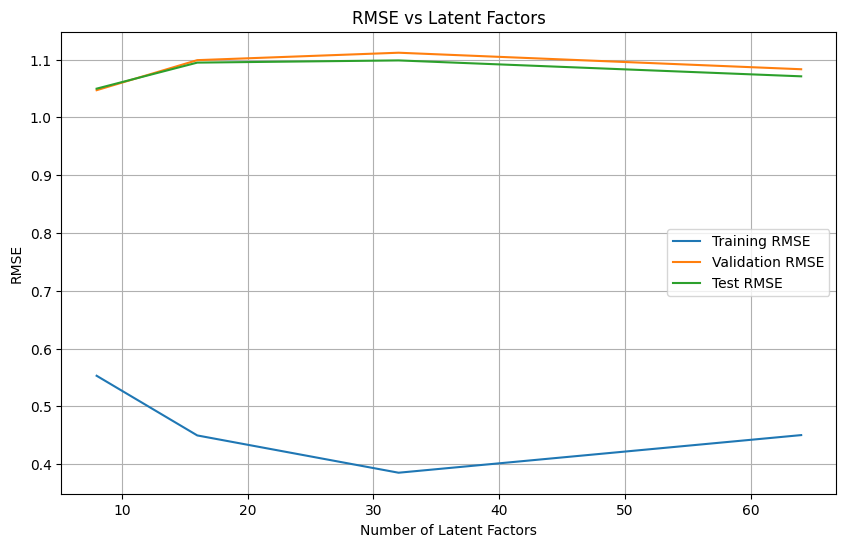

In [35]:
import matplotlib.pyplot as plt

latent_facs = [8,16,32,64]

training_times = []
train_rmses = []
valid_rmses = []
test_rmses = []

#Process of training the model with different number of latent factors
for fac in latent_facs:
  emodel = ExplicitFactorizationModel(n_iter=10,
                                    embedding_dim=fac,
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
  )
  current = time.time()
  emodel.fit(train, verbose=True)
  end = time.time()
  #Estimating training time
  diff = end - current
  training_times.append(diff)

  #Find RMSE for training, validation and test sets, then recording RMSE values
  train_rmse = rmse_score(emodel, train)
  train_rmses.append(train_rmse)

  test_rmse = rmse_score(emodel, test)
  test_rmses.append(test_rmse)

  valid_rmse = rmse_score(emodel, valid)
  valid_rmses.append(valid_rmse)

  print('Training times: ', training_times)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(latent_facs, train_rmses, label='Training RMSE')
plt.plot(latent_facs, valid_rmses, label='Validation RMSE')
plt.plot(latent_facs, test_rmses, label='Test RMSE')
plt.title('RMSE vs Latent Factors')
plt.xlabel('Number of Latent Factors')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.savefig('rmse_vs_latent_factors.png')
plt.show()



## Evaluating Other Models

When evaluating models, it's important to compare to some reasonable baselines.

Spotlight's `rmse_score()` method can be used to evaluate any Python object that adheres to the specification of the `predict()` function. For instance, we can make a baseline "static" scoring model, which returns the same scores for each user. This set of scores is passed as numpy array in the constructor.


In [36]:
class StaticModel:

  def __init__(self, staticscores):
    self.numitems = len(staticscores)
    assert isinstance(staticscores, np.ndarray), "Expected a numpy array"
    assert staticscores.dtype == np.float32 or staticscores.dtype == np.float64, "Expected a numpy array of floats"
    self.staticscores = staticscores

  # uids are the user(s) we are requesting recommendations for;
  # returns an array of scores, one for each item
  # the array is duplicated for each user requested
  def predict(self, uids, iids=None):
    # this model returns all zeros, regardless of userid

    # we respond to one or more uids
    uids = [uids] if isinstance(uids, int) else uids

    # if iids is specificed, we filter predicts for those userids
    # if iids is not specificed, predict() returns the prediction for each item _in iid order_
    iids = np.arange(self.numitems) if iids is None else iids
    return [self.staticscores[iids] for u in uids]

For instance, we can make a static baseline that just returns 0 for every item, regardless of the user.

In [37]:
mydummymodel = StaticModel(np.zeros(num_items))

print("Asking for 2 users, one item: " + str(mydummymodel.predict([0,1],0)))
print("Asking for one item: " + str(mydummymodel.predict(0,0)))
print("Asking for two items: " + str(mydummymodel.predict(0,[0,1])))
print("RMSE of our dummy model: %f" % rmse_score(mydummymodel, test))

Asking for 2 users, one item: [0.0, 0.0]
Asking for one item: [0.0]
Asking for two items: [array([0., 0.])]
RMSE of our dummy model: 3.642758


### Popularity-based Recommenders

Implement other baseline recommenders.
**Using ratings_df**, create three new instances of StaticModel as baselines:

(a). the number of ratings for each item - linearly normalise this to be in the range 0-5.

(b). the number of 5 scores received by an item - linearly normalise this to be in the range 0-5.

(c). the average rating value for each item (no need to normalise - scores are already 0-5)

Evaluate baseline models in terms of RMSE, as well as providing their scores for particular iids.

In [38]:
# function to implement linear normalization in range(0-5)
def lin_norm(array):
  min = np.min(array)
  max = np.max(array)
  norm_array = 5 * (array - min) / (max - min)
  return norm_array

#(a)
item_ratings_count = ratings_df.groupby('movieId').size()
item_ratings_count_norm = lin_norm(item_ratings_count)

#(b)
item_ratings_5_count = ratings_df[ratings_df['rating'] == 5].groupby('movieId').size()
item_ratings_5_count_norm = lin_norm(item_ratings_5_count)

#(b)
avg_item_ratings = ratings_df.groupby('movieId')['rating'].mean()

#mapping each movieId of the obtained series to its corresponding index in iid_map so that we got an array of same scores but with right indices
def get_score_i(series):
    scores = np.zeros(len(iid_map))
    for movieId, score in series.items():
        if movieId in iid_map:
            scores[iid_map[movieId]] = score
    return scores

#
a_scores = get_score_i(item_ratings_count_norm.fillna(0))
a_model = StaticModel(a_scores)

b_scores = get_score_i(item_ratings_5_count_norm.fillna(0))
b_model = StaticModel(b_scores)

c_scores = get_score_i(avg_item_ratings.fillna(0))
c_model = StaticModel(c_scores)

print("a:", rmse_score(a_model, test))
print("b:", rmse_score(b_model, test))
print("c:", rmse_score(c_model, test))

print(a_model.predict(0, 0))
print(b_model.predict(0, 0))
print(c_model.predict(0, 0))

a: 2.899816663013065
b: 3.330386784749741
c: 0.8810745544813008
[3.2621951219512195]
[1.513157894736842]
[3.9209302325581397]


In [39]:
print(avg_item_ratings)
print(iid_map)
print(a_scores)

movieId
m1         3.920930
m10        3.496212
m100       2.785714
m100044    4.000000
m100068    3.500000
             ...   
m99853     4.000000
m999       3.041667
m99910     3.250000
m99917     3.166667
m99992     3.000000
Name: rating, Length: 9724, dtype: float64
defaultdict(None, {'m1': 0, 'm3': 1, 'm6': 2, 'm47': 3, 'm50': 4, 'm70': 5, 'm101': 6, 'm110': 7, 'm151': 8, 'm157': 9, 'm163': 10, 'm216': 11, 'm223': 12, 'm231': 13, 'm235': 14, 'm260': 15, 'm296': 16, 'm316': 17, 'm333': 18, 'm349': 19, 'm356': 20, 'm362': 21, 'm367': 22, 'm423': 23, 'm441': 24, 'm457': 25, 'm480': 26, 'm500': 27, 'm527': 28, 'm543': 29, 'm552': 30, 'm553': 31, 'm590': 32, 'm592': 33, 'm593': 34, 'm596': 35, 'm608': 36, 'm648': 37, 'm661': 38, 'm673': 39, 'm733': 40, 'm736': 41, 'm780': 42, 'm804': 43, 'm919': 44, 'm923': 45, 'm940': 46, 'm943': 47, 'm954': 48, 'm1009': 49, 'm1023': 50, 'm1024': 51, 'm1025': 52, 'm1029': 53, 'm1030': 54, 'm1031': 55, 'm1032': 56, 'm1042': 57, 'm1049': 58, 'm1060': 59

### Implicit Recommendation

This part uses a music dataset from [Last.fm](https://www.last.fm/) -- a Spotify-like music streaming service -- that was obtained by a researcher at Pompeu Fabra University (Barcelona, Spain). The relevant citation is:

```
  @book{Celma:Springer2010,
      	author = {Celma, O.},
      	title = {{Music Recommendation and Discovery in the Long Tail}},
       	publisher = {Springer},
       	year = {2010}
      }
 ```

You can have more information about the dataset at [this link](http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html).

## Dataset preparation

The full Last.fm dataset is 2.4GB uncompressed. So we focus on a sample with 200k listens.

In [40]:
listens_df = pd.read_csv("https://www.dcs.gla.ac.uk/~craigm/recsysH/lastfm-200ksample-listens_df.csv.gz")


Let's look at the dataset. Note that the we don't have any explicit ratings by the users. We just know what they interacted with (and when).

In [41]:
listens_df.head()

,user,timestamp,artistid,artist,trackid,trackname
0,user_000593,2007-05-14T18:49:03Z,ad996aef-cc1c-42ac-af5c-619c370f4b8a,"Emerson, Lake & Palmer",NaN,Three Fates (Clotho/Lachesis/Atropos)
1,user_000093,2008-08-18T22:04:59Z,8c538f11-c141-4588-8ecb-931083524186,Bloc Party,315a301e-e764-4adf-91c6-e90a22320106,Positive Tension
2,user_000594,2008-04-06T10:57:45Z,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,Metallica,683c89fe-2be8-4ed2-8e58-68b2343cb8d5,Through The Never
3,user_000651,2008-05-10T07:14:45Z,3ca09fae-fdee-4771-bab9-244708515a98,Omarion,NaN,Ice Box [Orangefuzzz Weather Advisory Radio Mix]
4,user_000137,2009-03-11T23:17:22Z,af84ee9f-534a-4f7f-844b-188ba1c47e87,Los Rodríguez,76b83f07-3763-4c17-8d24-28040d85354a,Dulce Condena


## An implicit recommendation approach

Let's move away from explicit recommendation to implicit.

We will continue using the [Spotlight](https://github.com/maciejkula/spotlight/) toolkit for our recommender.

We can construct [Interaction](https://maciejkula.github.io/spotlight/interactions.html) objects for Spotlight in the same way as before. The only difference is that this time we do not record the user's ratings.


In [42]:
from collections import defaultdict
from itertools import count

#we cant trust the musicbrainz ids to exist, so lets build items ids based on artist & trackname attributes
LFMiid_map = defaultdict(count().__next__)
LFMiids = np.array([LFMiid_map[str(artist)+"/"+str(trackname)] for artist,trackname in listens_df[["artist","trackname"]].values ], dtype=np.int32)

LFMuid_map = defaultdict(count().__next__)
LFMuids = np.array([LFMuid_map[uid] for uid in listens_df["user"].values ], dtype=np.int32)
#freeze uid_map and iid_map so no more mapping are created
LFMuid_map.default_factory = None
LFMiid_map.default_factory = None

LFMuid_rev_map = {v: k for k, v in LFMuid_map.items()}
LFMiid_rev_map = {v: k for k, v in LFMiid_map.items()}

from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

#NB: we will set num_users and num_items here - its a good practice.
imp_dataset = Interactions(user_ids=LFMuids, item_ids=LFMiids, num_users=len(LFMuid_map), num_items=len(LFMiid_map))
#we could add the timestamps here if we were doing sequence recommendation

#what have we got.
print(imp_dataset)
print()

<Interactions dataset (973 users x 125076 items x 200000 interactions)>



In [43]:
from spotlight.cross_validation import random_train_test_split

itrain, itest = random_train_test_split(imp_dataset, random_state=np.random.RandomState(SEED))
print(itrain)
print(itest)

<Interactions dataset (973 users x 125076 items x 160000 interactions)>
<Interactions dataset (973 users x 125076 items x 40000 interactions)>


Let's run Spotlight's impllicit Matrix Factorisation on this dataset. Here, we use a *pointwise* loss, which just tries to predict whether the user will like the item or not. It does not use the BPR loss function .

In [44]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time

imodel = ImplicitFactorizationModel(n_iter=5,
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

imodel.fit(itrain, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds" % (diff))

Epoch 0: loss 0.9663112604141235
Epoch 1: loss 0.4953250312805176
Epoch 2: loss 0.1903692701101303
Epoch 3: loss 0.11518943915367126
Epoch 4: loss 0.08347183756828308
Training took 124 seconds


Again, we can look at the predictions. We make a prediction (a score ) for ALL items for user uid 0. Note that the scores vary in magnitude - indeed, we're not predicting a rating, we just need to have scores in order to rank the items in descending order.

In [45]:
print(imodel.predict(0))
print(len(imodel.predict(0)))

[ -4.7577653   5.261051   -9.298162  ...  -9.027732  -11.657818
 -13.502151 ]
125076


Now that we have the scores of all items for a given user, we need to identify the top-scored ones, i.e. those that we would present to the user.

Track Analysis

Function `tracksForUser(user)` identifies the artist name & track of the top K (e.g. K=4) items based on their prediction scores of `imodel` for a given user index index (i.e. 0.. 964).

In [46]:
def tracksForUser(userId, k=4):
  top_tracks = []

  predictions = imodel.predict(userId)
  top_predictions_indeces = np.argsort(predictions)[::-1][:k]

  for i in top_predictions_indeces:
    # track = (LFMiid_rev_map[i], listens_df.iloc[i-1]["artist"], listens_df.iloc[i]["trackname"])
    top_tracks.append(LFMiid_rev_map[i])

  print(top_tracks)


# top 10 items for user uId = 4
tracksForUser(4, 10)

['Evanescence/Sweet Sacrifice', 'Mgmt/Kids', 'The Killers/Bones', 'Nelly Furtado/Say It Right', 'Kings Of Leon/Use Somebody', 'Amy Winehouse/Back To Black', 'Red Hot Chili Peppers/The Zephyr Song', 'Radiohead/Fake Plastic Trees', 'Incubus/Drive', 'Him/The Funeral Of Hearts']


### Artist Analysis

We look at the artists actually listened to by uid 4, and compare/contrast with the predictions of the recommender. It's useful to examine how many times each artist was listened to.


In [47]:
userId = LFMuid_rev_map[4]
print(userId)

uid4_counts = listens_df[listens_df['user'] == userId].groupby('artist')['trackname'].count().reset_index(name='count')
uid4_counts = uid4_counts.sort_values(by="count", ascending=False)

uid4_counts.head()


user_000137


,artist,count
119,Soda Stereo,39
55,Gustavo Cerati,36
104,Radiohead,31
82,Lucybell,27
114,Silvio Rodríguez,16


I observed that uid 4 listened frequently to "Radiohead" (rank 3), while a Radiohead song was among the top 10 ranked songs in our predicted model.

## Evaluating an implicit recommender




We can examine the MRR of the implicit model we have learned. We pass it the test set (which contains knowledge of what the user *actually* clicked), as our ground truth.

In the second variant, we also pass the training data. Calculate MRR Score

In [48]:
from spotlight.evaluation import mrr_score

#evaluate on this dataset takes approx 1 minute
!date
print(mrr_score(imodel, itest).mean())
!date
print(mrr_score(imodel, itest,  train=itrain).mean())
!date


Thu May 23 01:05:10 PM UTC 2024
0.03720125940064275
Thu May 23 01:05:43 PM UTC 2024
0.008104536778740273
Thu May 23 01:06:17 PM UTC 2024


Interpret an MRR score - we know it has a range [0,1] with 1 being best. 1 means, on average across all users, we make a relevant prediction at rank 1; 0.5 means, on average, at rank 2. This is a very rough rule-of-thumb - MRR isn't a linear measure, so  a few poor predictions affect the average more than a few good ones.

**More information:**

rankdata() is a very useful function. Here's an example of its output:
```python
>>> rankdata([0, 2, 3, 2])
array([1. , 2.5, 4. , 2.5])
```

It tells us the RANK of the number at each position. So the first element of the array (value 0) was the smallest, so is "rank 1"; the highest value gets "rank 4"; the other two values are tied, so they get equal ranks (2.5 is halfway between 2 & 3). We can adjust this tie-breaking behaviour using the `method=` kwarg.

You can now answer all questions for Task 8.

### Listens and Recommendations

We now want to analyse how the recommender predictions differs from what it was trained on, to understand recommender performance

We can see the models performance by using `mrr_score(imodel, itest)`.

*   Pick the user with the lowest uid that has the highest RR. How many listens (ie. how many times they have listened to any song) did they have in the training dataset (as represented by `itrain`)?
*   Similarly, pick the user with the lowest uid that had the lowest RR. How many listens did they have in the training dataset (`itrain`)?


In [49]:
scores = mrr_score(imodel, itest)

#pick the user with the lowest uid that has the highest RR
highest_score_i = scores.argmax()
highest_score_user = LFMuid_rev_map[highest_score_i]
num_listens_highest = len(itrain.user_ids[itrain.user_ids == highest_score_i])

#pick the user with the lowest uid that had the lowest RR
lowest_score_i = scores.argmin()
lowest_score_user = LFMuid_rev_map[lowest_score_i]
num_listens_lowest = len(itrain.user_ids[itrain.user_ids == lowest_score_i])

# print(highest_score_user)
# print(num_listens_highest)

# print(lowest_score_user)
# print(num_listens_lowest)

useri_rr_1 = np.argmax(scores == 1)
uid_rr_1 = LFMuid_rev_map[useri_rr_1]
num_listens_1 = len(itrain.user_ids[itrain.user_ids == useri_rr_1])
# print(uid_rr_1)
# print(num_listens_1)

useri_rr_0 = np.argmax(scores == 0)
uid_rr_0 = LFMuid_rev_map[useri_rr_0]
num_listens_0 = len(itrain.user_ids[itrain.user_ids == useri_rr_0])
# print(uid_rr_0)
# print(num_listens_0)


Next, make a numpy array containing the number of listens for each uid in `itrain`. Plot a histogram of the distribution.

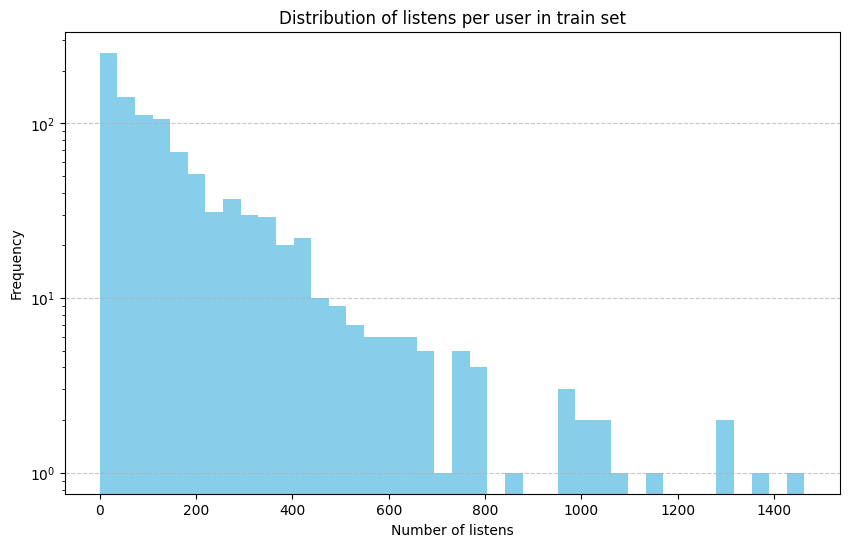

In [50]:
listen_counts = [len(itrain.user_ids[itrain.user_ids == uid]) for uid in range(len(LFMuid_rev_map))]

#plotting a histogram of the distribution
plt.figure(figsize=(10, 6))
plt.hist(listen_counts, bins='auto', color='skyblue', log=True)
plt.title('Distribution of listens per user in train set')
plt.xlabel('Number of listens')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('listens_distribution.png')

plt.show()

Many users have very few listens. Lets set 20 listens as a threshold.

In [59]:
threshold = 20

listen_counts = np.bincount(itrain.user_ids)

# listen_counts = [len(itrain.user_ids[itrain.user_ids == uid]) for uid in range(len(LFMuid_rev_map))]
# listen_counts = np.array(listen_counts)

#evaluate the model for all users
mrr_scores = mrr_score(imodel, itest)

#filter indexes of cold start users and normal users
cold_start_users = np.where(listen_counts < threshold)[0]
normal_users = np.where(listen_counts >= threshold)[0]
# print(cold_start_user_i)

#take mrr_scores for exactly cold start and normal users and calculate mean values
mrr_cold_start = (mrr_scores[cold_start_users]).mean()
mrr_normal = (mrr_scores[normal_users]).mean()

print("MRR for cold-start users:", round(mrr_cold_start, 4))
print("MRR for all users:", round(mrr_normal, 4))


MRR for cold-start users: 0.0024
MRR for all users: 0.0441


## BPR

Finally, let's compare the *pointwise* implicit factorisation model with Bayesian Personalised Ranking (BPR). BPR is a very key recommendation model in the literature, which is widely used today as a baseline in many research papers.

Train an ImplicitFactorizationModel on the Last FM dataset (i.e. `itrain`) using identical settings as before, except adding `loss='bpr'`. Record the time taken to train, and the evaluate its effectiveness in terms of MRR. Do NOT use the `train=itrain` argument to `mrr_score()`.

In [52]:
imodelbpr = ImplicitFactorizationModel(n_iter=5,
                                    loss='bpr',
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

imodelbpr.fit(itrain, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds" % (diff))

mrrscore = mrr_score(imodelbpr, itest).mean()

print('MRR score with BPR loss:', mrrscore)


Epoch 0: loss 0.47409727311134336
Epoch 1: loss 0.14683696229457854
Epoch 2: loss 0.02480817346572876
Epoch 3: loss 0.014375450010970235
Epoch 4: loss 0.011113866971805691
Training took 132 seconds
MRR score with BPR loss: 0.05814735966328977


As we see, BPR on our dataset resulted in enhanced effectivness, though not very considerable (only 0.014 better)